In [1]:
from audiot import *

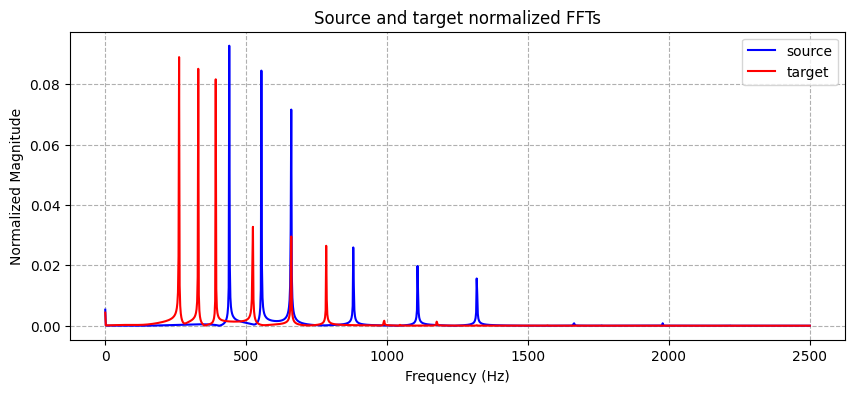

In [2]:
sr = 44100
duration = 0.5
smooth_len = 100
max_frequency = 2500

source_path = SOUNDS / 'digital/A_digital.wav'
target_path = SOUNDS / 'digital/C_digital.wav'

source_signal = load_signal(source_path, sr=sr, duration=duration, smooth_len=smooth_len)
target_signal = load_signal(target_path, sr=sr, duration=duration, smooth_len=smooth_len)

source_fft, support = fft_normalized(source_signal, sr=sr, return_support=True, max_frequency=max_frequency)
target_fft = fft_normalized(target_signal, sr=sr, max_frequency=max_frequency)

plot_signals(support, signals=[source_fft, target_fft], labels=['source', 'target'], title='Source and target normalized FFTs', colors=['b', 'r'])

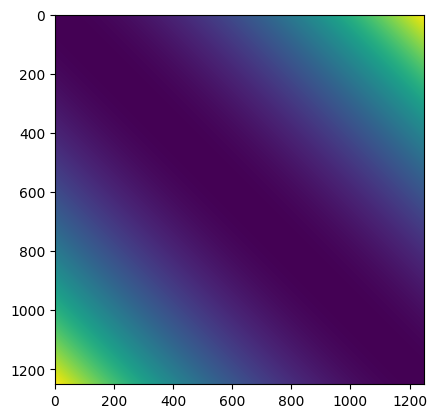

In [3]:
# Optimal transport

alpha = 0.5

M = cost_matrix(support)

plt.imshow(M)

In [4]:
interpolation, plan = emd(support, source_fft, target_fft, M, alpha)

lambd = 1e-1

max_nz = 50  # two non-zero entries are permitted per column of the OT plan
sparse_plan = ot.smooth.smooth_ot_dual(source_fft, target_fft, M, lambd, reg_type="sparsity_constrained", max_nz=max_nz)

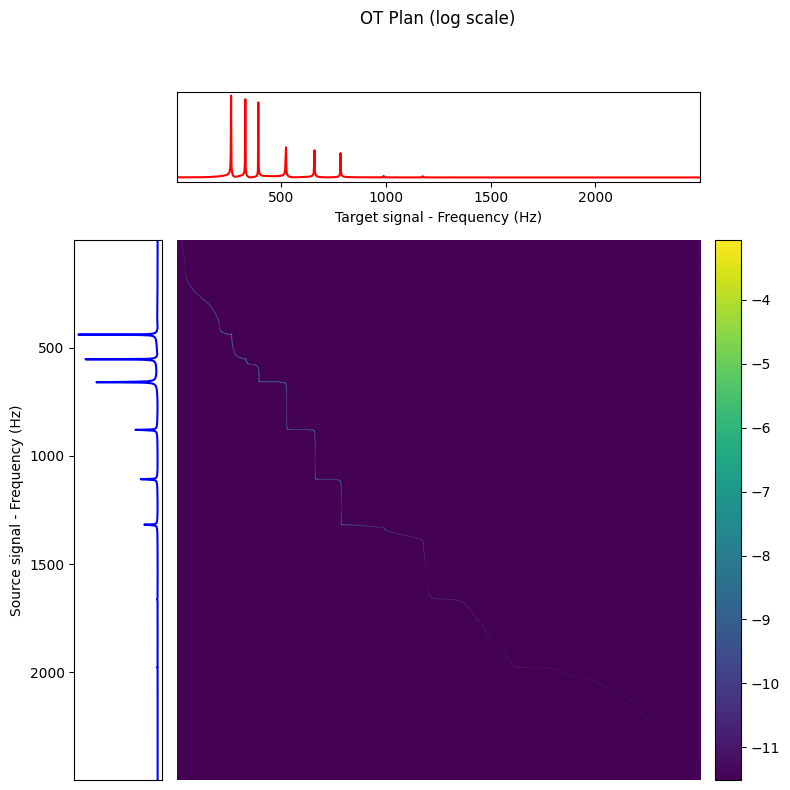

In [5]:
source_freq_start=0
source_freq_end=-1
target_freq_start=0
target_freq_end=-1
plot_plan_spectra(support, 
                  source_fft, 
                  target_fft, 
                  plan, 
                  source_freq_start=source_freq_start, 
                  source_freq_end=source_freq_end, 
                  target_freq_start=target_freq_start, 
                  target_freq_end=target_freq_end, 
                  log=True, 
                  epsilon=1e-5)


In [7]:
sparse_plan = csr_matrix(sparse_plan)
sparse_interpolation = np.zeros(len(support))
row, col = sparse_plan.nonzero()

for f_s, f_t in zip(row, col):
    index = interpolate_frequency(f_s, f_t, alpha=alpha)
    sparse_interpolation[index] += sparse_plan[f_s, f_t]

sparse_plan = np.array(sparse_plan.todense())

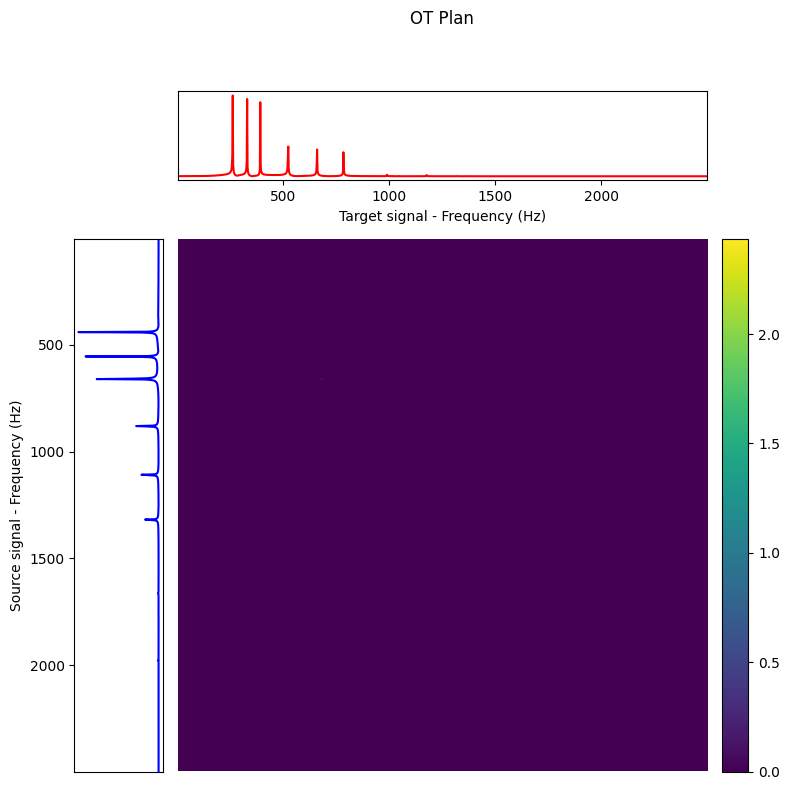

In [8]:
source_freq_start=0
source_freq_end=-1
target_freq_start=0
target_freq_end=-1
plot_plan_spectra(support, 
                  source_fft, 
                  target_fft, 
                  sparse_plan, 
                  source_freq_start=source_freq_start, 
                  source_freq_end=source_freq_end, 
                  target_freq_start=target_freq_start, 
                  target_freq_end=target_freq_end, 
                  log=False, 
                  epsilon=1e-10)


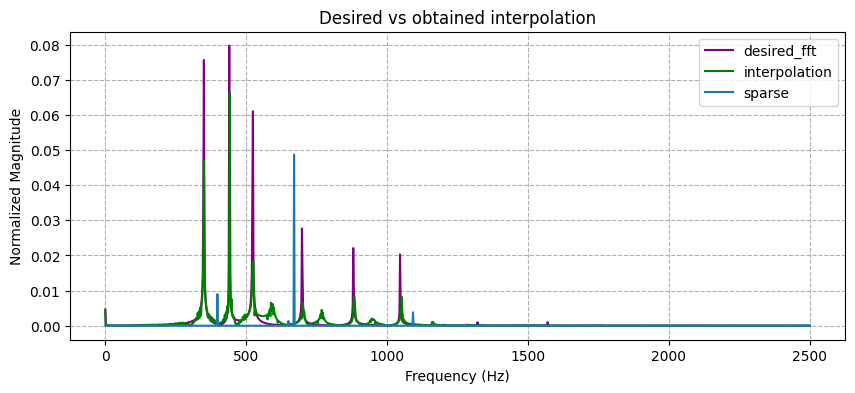

In [9]:
desired_interpolation = SOUNDS / 'digital/F_digital.wav'

desired_signal = load_signal(desired_interpolation, sr=sr, duration=duration, smooth_len=smooth_len)

desired_fft = fft_normalized(desired_signal, sr=sr, return_support=False, max_frequency=max_frequency)

plot_signals(support, signals=[desired_fft, interpolation, sparse_interpolation / 50], labels=['desired_fft', 'interpolation', 'sparse'], title='Desired vs obtained interpolation', colors=['purple', 'g'])

In [10]:
def complex_interpolation(interpolation, source, target, alpha):
    phase = (1 - alpha) * np.angle(source) + alpha * np.angle(target)

    return interpolation * np.exp(1j * phase)

complex_interpolation_1 = np.fft.irfft(complex_interpolation(interpolation_1, source_fft, target_fft, alpha), n=source_signal.shape[0])
complex_interpolation_2 = np.fft.irfft(complex_interpolation(interpolation_2, source_fft, target_fft, alpha), n=source_signal.shape[0])
complex_interpolation_3 = np.fft.irfft(complex_interpolation(interpolation_3, source_fft, target_fft, alpha), n=source_signal.shape[0])
complex_interpolation_4 = np.fft.irfft(complex_interpolation(interpolation_4, source_fft, target_fft, alpha), n=source_signal.shape[0])

signals = [source_signal, target_signal, complex_interpolation_1, complex_interpolation_2, complex_interpolation_3, complex_interpolation_4]
titles = ['source', 'target', 'interpolation 1' , 'interpolation 2', 'interpolation 3' , 'interpolation 4']
audio_widgets = [audio_widget(signal, title) for signal, title in zip(signals, titles)]

grid = widgets.VBox(audio_widgets)
grid

NameError: name 'interpolation_1' is not defined